# ++ Carregar dados históricos da Bovespa em Dataframe para análise ++

In [1]:
from datetime import date, datetime, timedelta
import time
hoje = datetime.today().strftime('%d/%m/%Y')
time.asctime( time.localtime(time.time()) )

'Wed Oct 16 16:36:20 2024'

In [2]:
import pandas as pd
from ipywidgets import IntProgress
import ipywidgets as widgets
import json
from bs4 import BeautifulSoup
pd.__version__

'1.3.4'

In [3]:
from IPython.display import FileLink, FileLinks, display, clear_output, Markdown
FileLink('Resultados.ipynb')

C:\Users\F0435280\OneDrive - Banco do Brasil S.A\Área de Trabalho\Alexandre\StockManager-main\Resultados.ipynb

In [4]:
# Setando opção do Pandas para mostrar todas as linhas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Setando separador de milhar
pd.options.display.float_format = '{:,.2f}'.format

In [5]:
from pacote.functions import *

In [6]:
ano = time.localtime().tm_year
if time.localtime().tm_mon < 3:
    str_ano, str_nov_ant, str_dez_ant = f'A{ano}', f'M11{ano-1}', f'M12{ano-1}'
    LISTA_ARQUIVOS = [str_ano, str_nov_ant, str_dez_ant]
else:
    str_ano = f'A{ano}'
    LISTA_ARQUIVOS = [str_ano]

In [7]:
df = carrega_dados(LISTA_ARQUIVOS)

In [8]:
# Monday is 0 and Sunday is 6.
dia_semana  = datetime.today().weekday()
ajuste_dias = -3 if dia_semana == 0 else -1
dt_esperado_ult = (datetime.today() + timedelta(days=ajuste_dias)).strftime('%Y-%m-%d')
dt_max = str(df["dtPregao"].max()).split()[0]

if dt_esperado_ult == dt_max:
    font_color="alert-success"
    a = "Atualizado!"
else:
    font_color="alert-danger"
    a = "Desatualizado!!! Última data " + str(dt_max)
def printmd(string):
    display(Markdown(string))

In [9]:
#  df_n_dias | vol | col_pc | pc_min | avg_vr_fech

style, layout, max_count, parm_vol = {'description_width':'initial'}, {'width':'400px'}, 7, 6000000
bar = IntProgress(min=0, max=max_count, style=style, layout=layout) # instantiate the bar
display(bar) # display the bar

d25 = monta_tabela(monta_df_periodos(df, 25), parm_vol, '1.0%', 24, 1, bar)
d20 = monta_tabela(monta_df_periodos(df, 20), parm_vol, '1.0%', 19, 1, bar)
d15 = monta_tabela(monta_df_periodos(df, 15), parm_vol, '1.0%', 14, 1, bar)
d10 = monta_tabela(monta_df_periodos(df, 10), parm_vol, '1.0%', 9, 1, bar)
d05 = monta_tabela(monta_df_periodos(df, 5), parm_vol, '1.0%', 5, 1, bar)
d04 = monta_tabela(monta_df_periodos(df, 4), parm_vol, '1.0%', 4, 1, bar)
d03 = monta_tabela(monta_df_periodos(df, 3), parm_vol, '1.0%', 3, 1, bar)
merge1 = pd.merge(d25['cdAcao'], d20['cdAcao'], how ='inner', on =['cdAcao'])
merge2 = pd.merge(merge1, d15['cdAcao'], how ='inner', on =['cdAcao'])
merge3 = pd.merge(merge2, d10['cdAcao'], how ='inner', on =['cdAcao'])
merge_final = pd.merge(merge3, d05['cdAcao'], how ='inner', on =['cdAcao'])
if merge_final.empty:
    merge_final = ">> Sem ações boas em todo o período <<"

IntProgress(value=0, layout=Layout(width='400px'), max=7, style=ProgressStyle(description_width='initial'))

In [10]:
if len(d05) > 5:
    df_button = d05
    print("d05")
elif len(d04) > 5:
    df_button = d04
    print("d04")
else:
    df_button = d03
    print("d03")

button0 = widgets.Button(description=f'{"0-"}{df_button["cdAcao"].iloc[0]}') if df_button["cdAcao"].size > 0 else None
button1 = widgets.Button(description=f'{"1-"}{df_button["cdAcao"].iloc[1]}') if df_button["cdAcao"].size > 1 else None
button2 = widgets.Button(description=f'{"2-"}{df_button["cdAcao"].iloc[2]}') if df_button["cdAcao"].size > 2 else None
button3 = widgets.Button(description=f'{"3-"}{df_button["cdAcao"].iloc[3]}') if df_button["cdAcao"].size > 3 else None
button4 = widgets.Button(description=f'{"4-"}{df_button["cdAcao"].iloc[4]}') if df_button["cdAcao"].size > 4 else None
button5 = widgets.Button(description=f'{"5-"}{df_button["cdAcao"].iloc[5]}') if df_button["cdAcao"].size > 5 else None
button6 = widgets.Button(description=f'{"6-"}{df_button["cdAcao"].iloc[6]}') if df_button["cdAcao"].size > 6 else None
output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output()
        index = int(b.description[0])
        display(consulta_acao_formatada(df, df_button['cdAcao'].iloc[index])[:-1])

lista_buttons = []
if button0:
    button0.on_click(on_button_clicked)
    lista_buttons.append(button0)
if button1:
    button1.on_click(on_button_clicked)
    lista_buttons.append(button1)
if button2:
    button2.on_click(on_button_clicked)
    lista_buttons.append(button2)
if button3:
    button3.on_click(on_button_clicked)
    lista_buttons.append(button3)
if button4:
    button4.on_click(on_button_clicked)
    lista_buttons.append(button4)
if button5:
    button5.on_click(on_button_clicked)
    lista_buttons.append(button5)
if button6:
    button6.on_click(on_button_clicked)
    lista_buttons.append(button6)

d05


In [11]:
ativos_dividendos_hoje = busca_ativos_dividendos()
ativos_dividendos_hoje

In [13]:
# Setando definição de cores
def color_red_dividend(val):
    color = 'red' if val in ativos_dividendos_hoje else 'black'
    return 'color: %s' % color

In [49]:
d25_format = d25.style.applymap(color_red_dividend, subset=['cdAcao'])
d20_format = d20.style.applymap(color_red_dividend, subset=['cdAcao'])
d15_format = d15.style.applymap(color_red_dividend, subset=['cdAcao'])
d10_format = d10.style.applymap(color_red_dividend, subset=['cdAcao'])
d05_format = d05.style.applymap(color_red_dividend, subset=['cdAcao'])
d04_format = d04.style.applymap(color_red_dividend, subset=['cdAcao'])
d03_format = d03.style.applymap(color_red_dividend, subset=['cdAcao'])
d25_format = d25_format.format(
    {"AvgVol": "{:,.2f}".format,"AvgVrFech": "{:,.2f}".format,"AvgPcAbert": "{:,.2f}".format})
d20_format = d20_format.format(
    {"AvgVol": "{:,.2f}".format,"AvgVrFech": "{:,.2f}".format,"AvgPcAbert": "{:,.2f}".format})
d15_format = d15_format.format(
    {"AvgVol": "{:,.2f}".format,"AvgVrFech": "{:,.2f}".format,"AvgPcAbert": "{:,.2f}".format})
d10_format = d10_format.format(
    {"AvgVol": "{:,.2f}".format,"AvgVrFech": "{:,.2f}".format,"AvgPcAbert": "{:,.2f}".format})
d05_format = d05_format.format(
    {"AvgVol": "{:,.2f}".format,"AvgVrFech": "{:,.2f}".format,"AvgPcAbert": "{:,.2f}".format})
d04_format = d04_format.format(
    {"AvgVol": "{:,.2f}".format,"AvgVrFech": "{:,.2f}".format,"AvgPcAbert": "{:,.2f}".format})
d03_format = d03_format.format(
    {"AvgVol": "{:,.2f}".format,"AvgVrFech": "{:,.2f}".format,"AvgPcAbert": "{:,.2f}".format})

In [50]:
printmd(f'**<div class={font_color}>{hoje}, Arquivo {a}</div>**')

**<div class=alert-success>16/10/2024, Arquivo Atualizado!</div>**

### 25 dias, order by 1%

In [51]:
d25_format if not d25.empty else print('<< Sem ações boas para 25 dias >>')

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
163,AZUL4,24,24,21,20,16,15,120,"225,698,170.96",5.62,1.21


### 20 dias, order by 1%

In [52]:
d20_format if not d20.empty else print('<< Sem ações boas para 20 dias >>')

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
162,AZUL4,19,19,17,16,13,12,96,"217,908,853.75",5.78,0.93


### 15 dias, order by 1%

In [53]:
d15_format if not d15.empty else print('<< Sem ações boas para 10 dias >>')

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
1606,QUAL3,14,14,13,13,12,10,76,"15,027,256.27",2.14,0.12
161,AZUL4,14,14,12,12,9,8,69,"200,973,033.67",5.91,1.28


### 10 dias, order by 1%

In [54]:
d10_format if not d10.empty else print('<< Sem ações boas para 10 dias >>')

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
1256,M2ST34,9,9,8,8,8,8,50,"24,659,063.82",14.84,1.29
1551,QUAL3,9,9,9,9,8,6,50,"15,769,695.30",2.15,0.08
111,AMBP3,9,9,9,8,7,6,48,"33,523,791.70",133.73,0.18
1458,PCAR3,9,9,8,7,7,7,47,"50,862,848.30",3.06,-0.09
2048,YDUQ3,9,9,9,9,6,4,46,"58,868,941.80",10.07,-0.02
1396,NVDC34,10,10,9,8,4,4,45,"115,794,639.20",15.00,0.82
159,AZUL4,9,9,7,7,5,5,42,"188,787,063.10",5.99,1.84
1874,TSMC34,9,9,6,4,3,2,33,"8,047,940.70",128.35,0.57


### 5 dias, order by 1%

In [55]:
d05_format

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
1480,QUAL3,5,5,5,5,5,4,29,"10,422,661.80",2.17,0.30
1388,PCAR3,5,5,5,4,4,4,27,"61,675,800.00",3.21,-0.07
502,CEAB3,5,5,5,4,4,3,26,"45,843,612.20",10.89,0.32
107,AMBP3,5,5,5,4,3,3,25,"34,690,676.80",132.57,1.08
153,AZUL4,5,5,4,4,3,3,24,"166,051,871.40",5.97,0.76
1566,ROXO34,5,5,4,2,2,2,20,"32,818,547.37",12.87,0.69
1332,NVDC34,5,5,4,3,1,1,19,"113,373,641.49",15.66,0.54
1352,ONCO3,5,5,3,2,2,1,18,"8,735,508.00",4.58,0.09
113,AMZO34,5,5,3,2,2,0,17,"10,144,119.53",52.48,0.93
905,GOGL34,5,5,2,1,1,0,14,"16,133,811.83",76.38,0.37


In [56]:
d04_format

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
490,CEAB3,4,4,4,4,4,3,23,"53,612,711.75",11.15,0.66
1450,QUAL3,4,4,4,4,4,3,23,"9,985,443.75",2.20,0.37
104,AMBP3,4,4,4,3,3,3,21,"38,857,242.75",133.71,0.75
1224,MOVI3,4,4,4,3,3,3,21,"37,107,144.50",5.59,0.21
1358,PCAR3,4,4,4,3,3,3,21,"59,676,763.50",3.24,0.07
904,GUAR3,4,4,4,4,3,1,20,"9,740,499.00",8.05,-0.22
124,ASAI3,4,4,4,3,2,2,19,"187,645,296.50",6.88,1.43
481,CBAV3,4,4,4,3,2,2,19,"22,368,845.25",5.70,0.90
1374,PETZ3,4,4,4,3,2,2,19,"32,163,701.00",4.91,0.56
150,AZUL4,4,4,3,3,2,2,18,"161,661,377.50",5.92,0.87


In [57]:
d03_format

,cdAcao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
101,AMBP3,3,3,3,3,3,3,18,"46,753,927.33",136.02,1.13
109,ANIM3,3,3,3,3,3,3,18,"22,405,957.00",2.40,1.39
287,BITH11,3,3,3,3,3,3,18,"7,741,118.95",83.60,1.24
904,HASH11,3,3,3,3,3,3,18,"33,901,150.72",51.70,2.06
1141,M2ST34,3,3,3,3,3,3,18,"32,251,154.57",16.38,3.51
1193,MOVI3,3,3,3,3,3,3,18,"32,090,134.67",5.63,0.06
1326,PCAR3,3,3,3,3,3,3,18,"66,749,948.33",3.27,0.10
1410,QBTC11,3,3,3,3,3,3,18,"11,018,489.85",22.27,1.29
1416,QUAL3,3,3,3,3,3,3,18,"11,382,186.00",2.24,0.17
476,CEAB3,3,3,3,3,3,2,17,"64,343,330.67",11.44,0.75


In [58]:
printmd(f'**<div class={font_color}>{hoje}, Status {a}</div>**')

**<div class=alert-success>16/10/2024, Status Atualizado!</div>**

## Consulta ação específica

In [24]:
consulta_acao_formatada(df, "azul4")[:-1]

,cdAcao,dtPregao,vrFech,vrVolume,vrMaxDia,vrMinDia,vrAbert,pcVar,pcMaxDia,pcMinDia,pcAbert,i05,i10,i15,i20,i25,i30
335019,AZUL4,2024-10-15,5.88,"140,882,623",6.27,5.82,6.15,-2.97%,3.47%,-3.96%,1.49%,1,1,1,1,1,1
333217,AZUL4,2024-10-14,6.06,"121,761,161",6.06,5.80,5.93,2.19%,2.19%,-2.19%,0,1,1,1,1,,
331353,AZUL4,2024-10-11,5.93,"194,867,815",6.05,5.65,5.85,2.07%,4.13%,-2.75%,0.69%,1,1,1,1,1,1
329840,AZUL4,2024-10-10,5.81,"189,133,911",6.27,5.74,6.26,-5.99%,1.46%,-7.12%,1.29%,1,1,,,,
328169,AZUL4,2024-10-09,6.18,"183,613,847",6.50,6.11,6.20,0,5.18%,-1.13%,0.32%,1,1,1,1,1,1
326696,AZUL4,2024-10-08,6.18,"476,742,105",7.00,6.18,6.60,7.48%,21.74%,7.48%,14.78%,1,1,1,1,1,1
325016,AZUL4,2024-10-07,5.75,"94,708,314",6.02,5.71,5.92,-2.21%,2.38%,-2.89%,0.68%,1,1,1,1,,
323329,AZUL4,2024-10-04,5.88,"116,597,467",6.02,5.80,6.00,-1.01%,1.35%,-2.36%,1.01%,1,1,,,,
321693,AZUL4,2024-10-03,5.94,"196,452,034",6.24,5.86,6.08,-4.81%,0,-6.09%,-2.56%,,,,,,
319902,AZUL4,2024-10-02,6.24,"173,111,354",6.24,5.97,5.99,4.87%,4.87%,0.34%,0.67%,1,1,1,1,1,1


In [25]:
buttons = widgets.HBox(lista_buttons)
widgets.VBox([buttons, output])

## Ações presentes em todos os períodos

In [26]:
merge_final

,cdAcao
0,AZUL4


## Grandes Variações de Volume

In [27]:
gvv = grandes_variacoes_volume(df)
gvv if not gvv.empty else print('<< Sem ações com Grandes Variações de Volume >>')

,cdAcao,dtPregao_x,vrVolume_x,pcVar_x,vrFech_x,vrVolume_y,pcVar_y,vrFech_y,dtPregao_y
41,AESB3,2024-10-14,"65,168,977.00",0.09%,11.75,"334,968,087.00",-0.17%,11.73,2024-10-15
985,MTRE3,2024-10-14,"1,404,964.00",3.04%,3.73,"7,336,858.00",-0.27%,3.72,2024-10-15


In [28]:
try:
    df_json = pd.read_json("graficos.json")
    df_json = df_json.set_index("data")
except:
    df_json = pd.DataFrame()

In [29]:
list_datas, list_datas_dt, d05_count, d10_count, d15_count, d20_count, d25_count = [], [], [], [], [], [], []
df_temp, d05_temp, d10_temp, d15_temp, d20_temp, d25_temp =  df.copy(), d05.copy(), d10.copy(), d15.copy(), d20.copy(), d25.copy()
max_count = 20

bar = IntProgress(min=0, max=max_count*5, style=style, layout=layout) # instantiate the bar
display(bar) # display the bar

for i in range(0, max_count):
    dt_max = df_temp["dtPregao"].max()
    dt_max_str = str(dt_max)[0:10]
    list_datas.append(dt_max_str)
    
    if df_json.loc[(df_json.index == dt_max_str)].empty:
        d05_count.append(len(d05_temp))
        d10_count.append(len(d10_temp))
        d15_count.append(len(d15_temp))
        d20_count.append(len(d20_temp))
        d25_count.append(len(d25_temp))

        df_temp = df_temp.loc[df_temp["dtPregao"] != dt_max]
        d05_temp = monta_tabela(monta_df_periodos(df_temp, 5), 3000000, '1.0%', 5, 1, bar)
        d10_temp = monta_tabela(monta_df_periodos(df_temp, 10), 3000000, '1.0%', 9, 1, bar)
        d15_temp = monta_tabela(monta_df_periodos(df_temp, 15), 3000000, '1.0%', 14, 1, bar)
        d20_temp = monta_tabela(monta_df_periodos(df_temp, 20), 3000000, '1.0%', 18, 1, bar)
        d25_temp = monta_tabela(monta_df_periodos(df_temp, 25), 3000000, '1.0%', 22, 1, bar)
    else:
        d05_count.append(df_json.loc[dt_max_str]["qt_acoes_05"])
        d10_count.append(df_json.loc[dt_max_str]["qt_acoes_10"])
        d15_count.append(df_json.loc[dt_max_str]["qt_acoes_15"])
        d20_count.append(df_json.loc[dt_max_str]["qt_acoes_20"])
        d25_count.append(df_json.loc[dt_max_str]["qt_acoes_25"])
        
        df_temp = df_temp.loc[df_temp["dtPregao"] != dt_max]
    
        bar.value += 5 # signal to increment the progress bar

IntProgress(value=0, layout=Layout(width='400px'), style=ProgressStyle(description_width='initial'))

In [30]:
# df_temp.dtPregao

In [31]:
df_graficos = pd.DataFrame({'data': list_datas, \
                            'qt_acoes_05': d05_count, \
                            'qt_acoes_10': d10_count, \
                            'qt_acoes_15': d15_count, \
                            'qt_acoes_20': d20_count, \
                            'qt_acoes_25': d25_count  
                           })
df_graficos.to_json("graficos.json")

### Gráfico 05

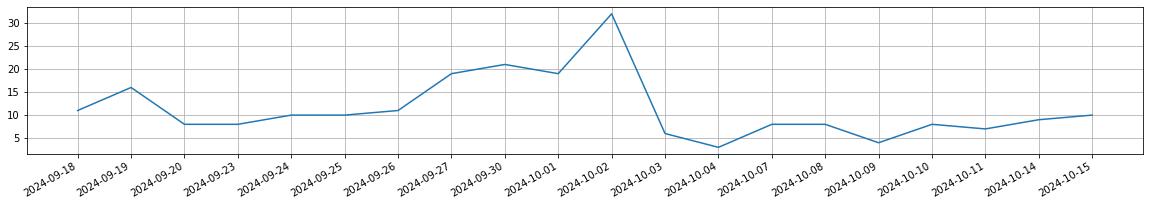

In [32]:
# gera_grafico(list_datas, d05_count)
gera_grafico(df_graficos['data'], df_graficos['qt_acoes_05'])

### Gráfico 10

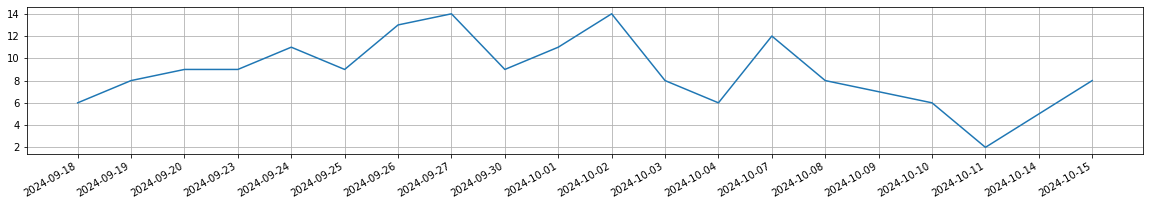

In [33]:
gera_grafico(df_graficos['data'], df_graficos['qt_acoes_10'])

### Gráfico 15

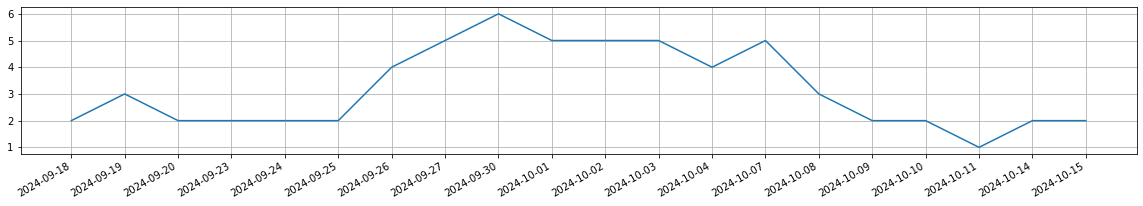

In [34]:
gera_grafico(df_graficos['data'], df_graficos['qt_acoes_15'])

### Gráfico 20

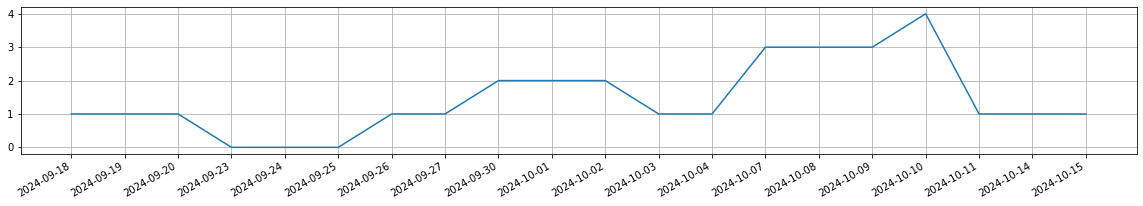

In [35]:
gera_grafico(df_graficos['data'], df_graficos['qt_acoes_20'])

### Gráfico 25

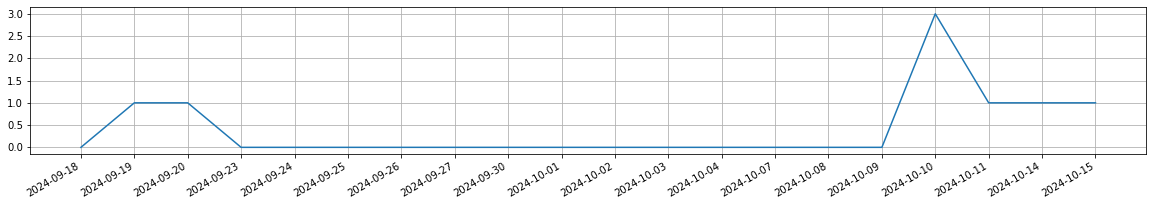

In [36]:
gera_grafico(df_graficos['data'], df_graficos['qt_acoes_25'])